### ロウソク足の描画
1分のロウソク足データを用いて、1時間ごとのチャートを描画する。

### 正解ラベルの付与
* 1分のロウソク足をダウンサンプリングし、1時間のロウソク足とする。このデータを用いて、下降/停滞/上昇の3パターンに分類する。
* ここでは、2015年から2020年までのデータを用いて、変化量の平均値と標準偏差を推定する。本来、未来の値は利用できないが、傾向分析により得られた結果という位置づけで利用する。
* また、変化量は、推定した分布（正規分布）に従うものとし、人手で決めた閾値で分類する。今回は、閾値を0.1とし、以下のように分類した。

| パターン | 条件 | クラス | ラベル |
| :--- | :--- | :--- | :--- |
| 下降 | 変化量が-0.1以下 | 0 | down |
| 停滞 | 変化量が-0.1より大きく0.1より小さい | 1 | stay |
| 上昇 | 変化量が0.1以上 | 2 | up |

In [1]:
import os
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

In [2]:
# データの読み込み
df = pd.read_csv('csv/concat_USDJPY2015_2020.csv', index_col='datetime', parse_dates=True)
create_chart = True

In [3]:
# 平均値と標準偏差を算出
def estimate_mean_std(df):
    target = df.resample('H').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'})
    series = target['close'].pct_change(1).shift(-1).fillna(0)
    print('mean: {:.15e}'.format(series.mean()))
    print('std:  {:.15e}'.format(series.std()))
    
    return series

# ヒストグラムの描画
def plot_histogram(series. threshold=0.1):
    # ヒストグラムの描画
    series_std = (series - series.mean()) / series.std()
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('Distribution of pct_change')
    ax.set_xlabel('pct_change')
    ax.set_ylabel('frequency')
    ax.set_ylim(0, 1.0)
    judge = series_std.abs() < threshold
    ax.hist(series_std,        bins=1000, range=(-5, 5), density=True, alpha=0.3, color='b')
    ax.hist(series_std[judge], bins=1000, range=(-5, 5), density=True, alpha=0.3, color='r')
    ax.grid()
    matched = series_std[judge].count()
    total = series_std.count()
    print('matched / total: {} / {} ({:.3%})'.format(matched, total, matched / total))
    
    return ax

In [4]:
class CreateDataset():
    def __init__(self, mean, std, df, root_dir='chart'):
        self.root_dir = root_dir
        self.mean = mean
        self.std = std
        # 1分のロウソク足の読み込み
        self.df = df.copy()
        # 1時間のロウソク足の作成
        self.downsampling = df.resample('H').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'}).dropna()

    def __get_output_path(self, time):
        output_filename = 'fig{}.png'.format(time.strftime('%Y%m%d%H%M'))
        output_path = os.path.join(self.root_dir, time.strftime('%Y/%m'), output_filename)
        
        return output_path
        
    # チャート出力用関数
    def plot_chart(self):
        indices = self.downsampling.index
        # 出力先のディレクトリ作成
        date = indices.to_series().apply(lambda date: date.strftime('%Y/%m'))
        dirs = date.drop_duplicates().to_list()
        for dirname in dirs:
            dir_path = os.path.join(self.root_dir, dirname)
            os.makedirs(dir_path, exist_ok=True)
        # figureの生成
        fig = mpf.figure(style='yahoo', figsize=(3, 3))
        # 余白の設定
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        # Axesの生成
        ax = fig.add_subplot(1, 1, 1)
        # plot
        for idx in indices:
            print(idx.strftime('%Y/%m/%d %H:%M'))
            mpf.plot(self.df[idx.strftime('%Y-%m-%d %H')], type='candle', ax=ax, tight_layout=True)
            # ラベルを削除
            ax.grid(False)
            ax.axes.xaxis.set_ticks([])
            ax.axes.yaxis.set_ticks([])
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
            ax.axis('off')
            fig.savefig(self.__get_output_path(idx))
            ax.clear()

        plt.close(fig)

    # チャートから正解ラベルを生成
    def create_groundtruth(self, threshold=0.1):
        # 差分抽出
        series = self.downsampling['close'].pct_change(1).shift(-1).fillna(0)
        series_std = (series - self.mean) / self.std
        # DataFrameの用意
        indices = self.downsampling.index
        ret_df = pd.DataFrame(index=indices, columns=['path', 'class', 'label'])
        ret_df['path'] = indices.to_series().apply(lambda time: self.__get_output_path(time))
        # 初期化（下降）
        ret_df['class'] = 0
        ret_df['label'] = 'down'
        # 「停滞する」部分の抽出
        judge = series_std.abs() < threshold
        ret_df.loc[judge, 'class'] = 1
        ret_df.loc[judge, 'label'] = 'stay'
        # 「上昇する」部分の抽出
        judge = series_std >= threshold
        ret_df.loc[judge, 'class'] = 2
        ret_df.loc[judge, 'label'] = 'up'

        return ret_df
    
# データセットの出力
def output_dataset(df, output_filename):
    df.to_csv(output_filename, header=True, index=False)

In [5]:
# ================
# データセット作成
# ================
threshold = 0.1
train_output_filename = 'train_dataset.csv'
test_output_filename = 'test_dataset.csv'
train_df = df[:'2019'].copy()
test_df = df['2020'].copy()

mean: -2.390418170110073e-06
std:  9.253835465544304e-04
matched / total: 19732 / 52584 (37.5247223490035%)


<AxesSubplot:title={'center':'Distribution of pct_change'}, xlabel='pct_change', ylabel='frequency'>

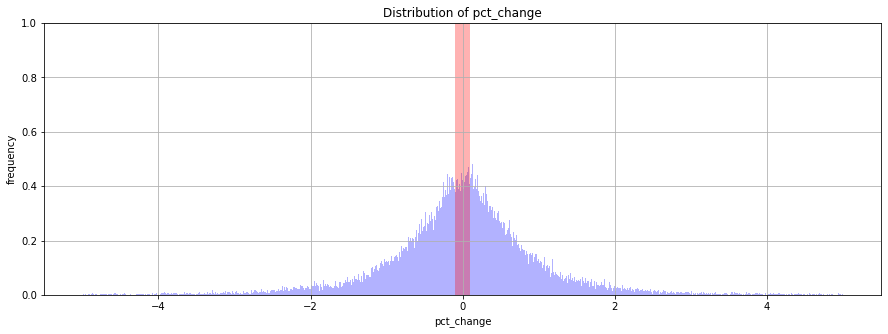

In [6]:
# データの推定
series = estimate_mean_std(df)
plot_histogram(series, threshold)

In [7]:
# インスタンス生成
mean, std = series.mean(), series.std()
train_creater = CreateDataset(mean, std, train_df)
test_creater = CreateDataset(mean, std, test_df)
# 正解ラベルの生成
output_train_df = train_creater.create_groundtruth(threshold)
output_test_df = test_creater.create_groundtruth(threshold)
output_dataset(output_train_df, train_output_filename)
output_dataset(output_test_df, test_output_filename)

if create_chart:
    # 時間のかかる処理
    train_creater.plot_chart()
    test_creater.plot_chart()

In [8]:
# データセットのパスの確認
for filename in [train_output_filename, test_output_filename]:
    out_df = pd.read_csv(filename)

    for row in out_df.itertuples():
        if not os.path.exists(row.path):
            print('{} does not exist'.format(row.path))